In [20]:
 # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from  sklearn.metrics import mean_squared_error

# I transformed the txt files into csv just because they are a bit simpler to manage
# and started with numerical data only

train = pd.read_csv("numerical_data.csv", sep=",")

In [21]:
 train.shape

(30001, 3)

In [22]:
train.head() 

,time,velocity,force
0,0.000,0.000000e+00,-0.000017
1,0.001,-7.000000e-09,-0.000017
2,0.002,-7.650000e-05,0.006806
3,0.003,-2.157000e-04,0.019206
4,0.004,-4.113000e-04,0.036630


In [23]:
 train.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [24]:
train.corr()


,time,velocity,force
time,1.00000,-0.014960,0.014950
velocity,-0.01496,1.000000,-0.999996
force,0.01495,-0.999996,1.000000


In [25]:
#from sklearn.preprocessing import StandardScaler

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
enc1=MinMaxScaler(feature_range=(0,1))



In [62]:
def Reshape_input(train,transform_only):
    timestep = 10
    # added transform to y too
    # tried with several timesteps (2, 10, 20, 100)
    #X ,y = train.iloc[:,:1],train.iloc[timestep:,2]
    X = train.iloc[:,1:]
    if transform_only:
        X= enc1.transform(X)
    else:
        X= enc1.fit_transform(X)
    X_3d = np.zeros((X.shape[0]-timestep,timestep,X.shape[1]))
    y = np.zeros((X.shape[0]-timestep,X.shape[1]))
    print(y.shape)
    
    for i in range(X_3d.shape[0]):
        X_3d[i,:,:] = X[i:i+timestep,:]
        y[i,:] = X[i+timestep,:]
    #y=enc1.fit_transform(np.array(train["force"]).reshape(-1,1))
    return enc1, X_3d, y


In [63]:
enc1, X, y = Reshape_input(train,transform_only=False)

(29991, 2)


In [64]:
X.shape

(29991, 10, 2)

In [65]:
print(X[0:2])

[[[0.49957592 0.49934961]
  [0.4995759  0.49934963]
  [0.4993183  0.49960732]
  [0.49884953 0.50007562]
  [0.49819083 0.5007337 ]
  [0.49734995 0.50157359]
  [0.49632856 0.50259364]
  [0.49512633 0.5037954 ]
  [0.49374158 0.50518214]
  [0.49217229 0.50675791]]

 [[0.4995759  0.49934963]
  [0.4993183  0.49960732]
  [0.49884953 0.50007562]
  [0.49819083 0.5007337 ]
  [0.49734995 0.50157359]
  [0.49632856 0.50259364]
  [0.49512633 0.5037954 ]
  [0.49374158 0.50518214]
  [0.49217229 0.50675791]
  [0.49041744 0.50852651]]]


In [66]:
y.shape

(29991, 2)

In [67]:
print(y[0:2])

[[0.49041744 0.50852651]
 [0.48847637 0.51048979]]


In [91]:
from keras.models import Sequential
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import *
model = Sequential()
# tried also with recurrent_dropout = 0.1 and activation='linear'
model.add(LSTM(18, input_shape=(X.shape[1], X.shape[2]), recurrent_dropout= 0))
# tried also commenting the following layer
model.add(Dense(18,kernel_initializer='normal',activation='relu'))
# tried also commenting dropout
model.add(Dropout(0))
# tried also commenting the following layer
model.add(Dense(2))
# tried also commenting the following layer instead
model.add(Dense(2,activation='linear'))
# added explicit lr to Adam optimizer, tried several values; 
# tried also with SGD with and without clipnorm (worse results than Adam)
model.compile(Adam(lr=0.01), loss='mean_squared_error')

checkpoint = ModelCheckpoint(filepath='model_lstm_yusra_weights.hdfs', save_weights_only=True,
                             monitor='val_loss',save_best_only=True)
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4,
                          verbose=0, mode='auto')
# tried also with smaller min_lr
RL = ReduceLROnPlateau(min_lr=0.0001,factor=0.3,patience=3)

In [96]:
# tried with batch sizes 32, 64, 128, 256
history = model.fit(X, y, epochs=100, batch_size=512,validation_split=0.2,
                  verbose=1, shuffle=False,callbacks=[checkpoint,RL,EarlyStop])

Train on 23992 samples, validate on 5999 samples
Epoch 1/100
23992/23992 [==============================] - 1s 22us/step - loss: 1.0236e-05 - val_loss: 9.6261e-06
Epoch 2/100
23992/23992 [==============================] - 0s 17us/step - loss: 9.8660e-06 - val_loss: 9.5602e-06
Epoch 3/100
23992/23992 [==============================] - 0s 17us/step - loss: 9.8246e-06 - val_loss: 9.5200e-06
Epoch 4/100
23992/23992 [==============================] - 0s 17us/step - loss: 9.7859e-06 - val_loss: 9.4795e-06
Epoch 5/100
23992/23992 [==============================] - 0s 17us/step - loss: 9.7465e-06 - val_loss: 9.4384e-06
Epoch 6/100
23992/23992 [==============================] - 0s 18us/step - loss: 9.7063e-06 - val_loss: 9.3966e-06
Epoch 7/100
23992/23992 [==============================] - 0s 19us/step - loss: 9.6653e-06 - val_loss: 9.3541e-06
Epoch 8/100
23992/23992 [==============================] - 0s 18us/step - loss: 9.6235e-06 - val_loss: 9.3109e-06
Epoch 9/100
23992/23992 [==============

Epoch 72/100
23992/23992 [==============================] - 0s 17us/step - loss: 5.0789e-06 - val_loss: 4.8060e-06
Epoch 73/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.9914e-06 - val_loss: 4.7222e-06
Epoch 74/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.9043e-06 - val_loss: 4.6386e-06
Epoch 75/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.8177e-06 - val_loss: 4.5551e-06
Epoch 76/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.7312e-06 - val_loss: 4.4710e-06
Epoch 77/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.6448e-06 - val_loss: 4.3863e-06
Epoch 78/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.5587e-06 - val_loss: 4.3022e-06
Epoch 79/100
23992/23992 [==============================] - 0s 17us/step - loss: 4.4733e-06 - val_loss: 4.2193e-06
Epoch 80/100
23992/23992 [==============================] - 0s 17us/step - loss:

In [97]:
pp=model.predict(X)

In [98]:
mean_squared_error(pp,y)

2.837858616296029e-06

In [99]:
# scale back and compute mse between force and predicted force
#pp.shape
pp_back=enc1.inverse_transform(pp)
#pp_back.shape
mean_squared_error(pp_back[:,1],train["force"][10:])

0.0025088271047674867

In [116]:
"""Step 2 - Make a dataframe with one  file from  Z=1.5"""

'Step 2 - Make a dataframe with one  file from  Z=1.5'

In [100]:
test = pd.read_csv("experimental_data.csv", sep=",")


In [101]:
test.head()

,time,velocity,force
0,0.000,0.0,0.0
1,0.001,0.0,0.0
2,0.002,0.0,0.0
3,0.003,0.0,0.0
4,0.004,0.0,0.0


In [103]:
test.dtypes

time        float64
velocity    float64
force       float64
dtype: object

In [104]:
enc1, X, y = Reshape_input(test,transform_only=False)

(29991, 2)


In [52]:
#X = X.reshape((X.shape[0], 1, X.shape[1]))

In [105]:
model.load_weights('model_lstm_yusra_weights.hdfs')

In [106]:
pred1=model.predict(X)
    

In [107]:
mean_squared_error(pred1,y)

1.7201114344242598e-05

In [112]:
pred1_back=enc1.inverse_transform(pred1)
#pp_back.shape
mean_squared_error(pred1_back[:,1],test["force"][10:])

0.016548071169969196

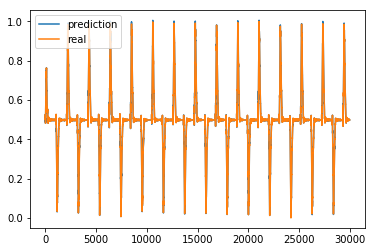

In [114]:
from matplotlib  import pyplot  as plt
plt.plot(list(pred1[:,1]), label='prediction')
plt.plot(list(y[:,1]), label='real')
plt.legend()
plt.show()

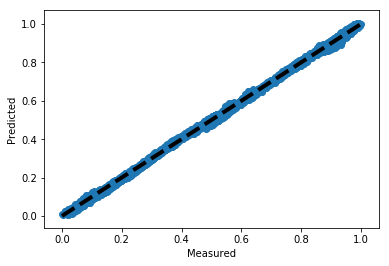

In [115]:
fig, ax=plt.subplots()
ax.scatter(y[:,1],pred1[:,1])
ax.plot([y[:,1].min(), y[:,1].max()],[y[:,1].min(), y[:,1].max()],'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [116]:
pd.DataFrame({'real':list(test["force"][10:]),'pred':list(pred1_back[:,1])} ) .to_csv('train_data_lstmyusra.csv',index=False)

In [61]:


#model.save('train_data_lstm_yusra.h5')

